# Metaheuristics for Single Allocation p-Hub Location Problem (SApHLP)

## This individual assessment is submitted by: Clarin Preetika D Souza

## Table of Contents


1. **[Problem Description](#problem)**


2. **[Importing Libraries](#libraries)**
 
 
3. **[HLP Functions](#functions)**


4. **[Neighbourhood Structures](#NS)**

 - 4.1 [Neighbourhood Structure 1](#NS1)
 - 4.2 [Neighbourhood Structure 2](#NS2)
 - 4.3 [Neighbourhood Structure 3](#NS3)
 - 4.4 [Neighbourhood Structure 4](#NS4)
 - 4.5 [Random Neighbourhood Selection](#NSF)
 
 
5. **[Metaheuristics](#meta)**

 - 5.1 [Simulated Annealing](#SA)
 - 5.2 [Variable Neighbourhood Descent](#VND)
 - 5.3 [Iterative Execution of Selected Algorithm](#IE)
 
 
6. **[Implementation](#implement)**

 - 6.1 [CAB 10 Nodes](#CAB10)
 - 6.2 [CAB 25 Nodes](#CAB25)
 - 6.3 [TR 55 Nodes](#TR55)
 - 6.4 [TR 81 Nodes](#TR81)
 - 6.5 [RGP 100 Nodes](#RGP100)
 
 
7. **[Sensitivity Analysis](#Sen)**

 - 7.1 [Simulated Annealing: Reducing Cooling Factor](#Sen1)
 - 7.2 [Variable Neighbourhood Descent: Reducing Maximum Neighbourhood Searched](#Sen2)

# Problem Description <a id='problem'></a>

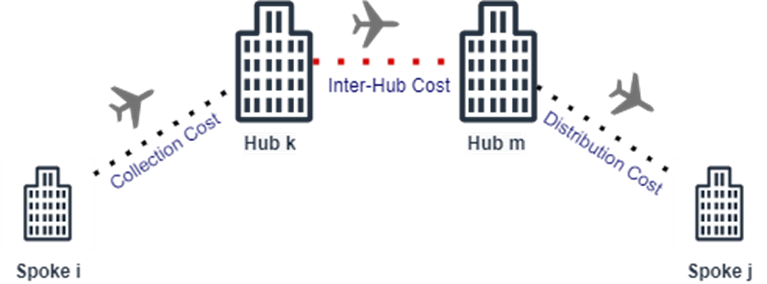

<div class="alert alert-block alert-info">
    
**Overview:** 

An uncapacitated single allocation p-hub location problem constructed in Python programming language and tested on CAB, TR and RGP for varying nodes. 

    
**Objective Function:** 
    
To select optimal hub location thereby minimising the total transportation cost

    
**Assumptions:** 

•	The number of hubs to be open is predetermined
    
•	A link is assumed to be present between every hub pair
    
•	There is economies of scale for using Inter-Hub connections
    
•	There is no direct path between spoke nodes
    
•	The transportation cost and flow demand between the nodes are constant and known in advance
    
•	The hubs have unlimited capacity and there is no limit for the number of spoke nodes that can be assigned to a particular hub
    
•	The transportation cost to be minimised as part of the objective function is assumed to be linearly dependent on the distance between the nodes

    
</div>

# Importing Libraries <a id='libraries'></a>

In [1]:
# Importing necessary packages to construct the SApHLP
import pandas as pd
import numpy as np
import random as rd
import math
from itertools import combinations
import time
import copy
from math import exp

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# HLP Functions <a id='functions'></a>

In [2]:
# Random initial solution generation
def initial_solution(n, p):
    hubs = rd.sample(range(len(n)), p) # select p random nodes as hubs
    initial_sol = [hubs[rd.randint(0,p-1)]+1 for i in range(len(n))] # allocate a random hub for each node
    for hub in hubs:
        initial_sol[hub] = hub+1 # allocate hubs to self
    return initial_sol

In [3]:
# Function to read demand details from excel and evaluate total_flow
def flow_matrix(excel_workbook, excel_sheet_name):
    flow = pd.read_excel(excel_workbook, sheet_name = excel_sheet_name, header = None)
    total_flow = flow.sum().sum()
    # Since node number count starts from 0, index and column of nodes are incremented by 1
    flow.index+=1
    flow.columns+=1
    return flow,total_flow

In [4]:
# Function to read unit cost details from excel
def cost_matrix(excel_workbook, excel_sheet_name):
    cost = pd.read_excel(excel_workbook, sheet_name = excel_sheet_name, header = None)
    # Since node number count starts from 0, index and column of nodes are incremented by 1
    cost.index += 1
    cost.columns += 1
    return cost

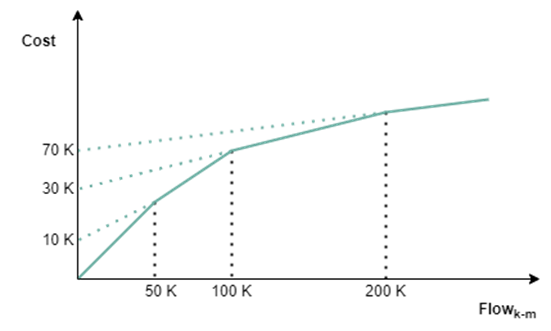

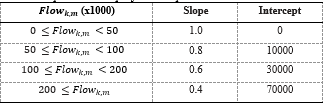

In [5]:
# Calculate unit flow cost
def evaluate_unit_flow_cost(flow):
    unit_flow_cost = 0
    
    if flow < 0:
        raise ValueError("Flow must be non negative")
    elif flow < 50000:
        unit_flow_cost = 0 + 1*flow
    elif flow < 100000:
        unit_flow_cost = 10000 + 0.8*flow
    elif flow < 200000:
        unit_flow_cost = 30000 + 0.6*flow
    else:
        unit_flow_cost = 70000 + 0.4*flow
        
    return unit_flow_cost

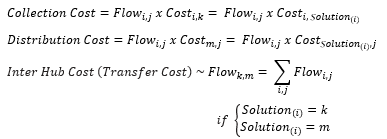

In [6]:
# Calculate total cost of the network
def evaluate_total_cost(current_solution, flow, cost):
    total_cost = 0
    
    # Identify hubs of the netowrk
    hubs = list(set(current_solution)) # Convert to a list before passing to set function
       
    # Calculating Collection Costs (CC) and Distribution Costs (DC)
    for i in range(1, len(current_solution)+1):
        for j in range(1, len(current_solution)+1):
            total_cost += flow[i][j] * (cost[i][current_solution[i-1]] + cost[current_solution[j-1]][j])
            
    # Calculating Inter-Hub Costs (IHC)
    for k in hubs:
        for m in hubs:
            if k!=m: # The two hubs chosen are distinct
                interhub_flow = 0
                for i in range(1, len(current_solution)+1):
                    for j in range(1, len(current_solution)+1):
                        if current_solution[i-1] == k and current_solution[j-1] == m:
                            interhub_flow += flow[i][j] # Calculating inter-hub flow
                            
                total_cost += evaluate_unit_flow_cost(interhub_flow) * cost[k][m]
                
    return round(total_cost,2)           

# Neighbourhood Structures <a id='NS'></a>

In [7]:
# Defining flow and cost to verify neighbourhood structure code logic
flow,total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','CAB10 Flow')
cost = cost_matrix('Soft Computing Validation Dataset.xlsx','CAB10 Cost')

## Structure 1: Replace a hub with one of the spoke nodes allocated to it <a id='NS1'></a>

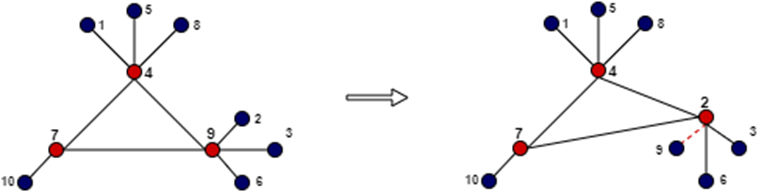

In [8]:
# Exploring neighbourhood structure 1

def NS1(current_solution, spoke):
    
    new_solution = copy.deepcopy(current_solution)
    hub = new_solution[spoke-1] # Current hub of the spoke node which will later be replaced
    
    for i in range(len(new_solution)):
        if new_solution[i] == hub: # Every occurence of old (current) hub should be replaced with new (earlier spoke) hub
            new_solution[i] = spoke
    
    return new_solution

In [9]:
# Generating a candidate solution with Steepest Descent Local Search Approach

def NS1_Steepest_Descent_Local_Search(current_solution, flow, cost):
    
    best_neighbourhood_solution = current_solution
    best_neighbourhood_cost = evaluate_total_cost(best_neighbourhood_solution, flow, cost)
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    # Evaluating costs for neighbourhoods created from list of spoke candidates
    for spoke in spokes:
        current_neighbourhood_solution = NS1(current_solution, spoke)
        current_neighbourhood_cost = evaluate_total_cost(current_neighbourhood_solution, flow, cost)
        # Compare costs of current solution with neighbourhood solution to select best neighbourhood
        if current_neighbourhood_cost < best_neighbourhood_cost:
            best_neighbourhood_solution = current_neighbourhood_solution
            best_neighbourhood_cost = current_neighbourhood_cost
            
    return best_neighbourhood_solution, best_neighbourhood_cost
    #return best_neighbourhood_solution

In [10]:
def NS1_Random_Local_Search(current_solution, flow, cost):
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    chosen_spoke = rd.choice(spokes)
    
    neighbourhood_solution = NS1(current_solution, chosen_spoke)
    neighbourhood_cost = evaluate_total_cost(neighbourhood_solution, flow, cost)
            
    return neighbourhood_solution, neighbourhood_cost

In [11]:
sample = [4, 9, 9, 6, 7, 9, 7, 9, 9, 9]

In [12]:
evaluate_total_cost(sample, flow, cost)

1193947424.1

In [13]:
NS1_Random_Local_Search(sample, flow, cost)

([4, 2, 2, 6, 7, 2, 7, 2, 2, 2], 1424356738.18)

## Structure 2: Swap hub allocation of two spoke nodes with each other keeping hubs same  <a id='NS2'></a>

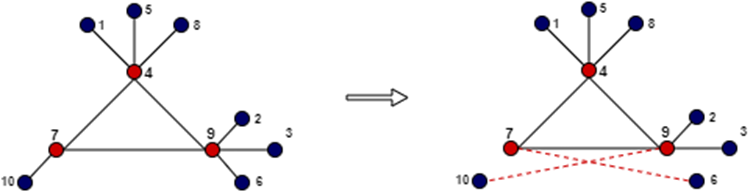

In [14]:
# Exploring neighbourhood structure 2

def NS2(current_solution, spoke1, spoke2):
    
    new_solution = copy.deepcopy(current_solution)
    hub1 = new_solution[spoke1-1] # Current hub of the spoke node 1 which will later be replaced by spoke node 2
    hub2 = new_solution[spoke2-1] # Current hub of the spoke node 2 which will later be replaced by spoke node 1
    
    new_solution[spoke1-1] = hub2
    new_solution[spoke2-1] = hub1
    
    return new_solution

In [15]:
# Generating a candidate solution with Steepest Descent Local Search Approach

def NS2_Steepest_Descent_Local_Search(current_solution, flow, cost):
    
    best_neighbourhood_solution = current_solution
    best_neighbourhood_cost = evaluate_total_cost(best_neighbourhood_solution, flow, cost)
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    # Evaluating costs for neighbourhoods created from list of spoke candidates
    for spoke1 in spokes:
        for spoke2 in spokes:
            if spoke1 != spoke2:
                current_neighbourhood_solution = NS2(current_solution, spoke1,spoke2)
                current_neighbourhood_cost = evaluate_total_cost(current_neighbourhood_solution, flow, cost)
                # Compare costs of current solution with neighbourhood solution to select best neighbourhood
                if current_neighbourhood_cost < best_neighbourhood_cost:
                    best_neighbourhood_solution = current_neighbourhood_solution
                    best_neighbourhood_cost = current_neighbourhood_cost
            
    return best_neighbourhood_solution, best_neighbourhood_cost
    #return best_neighbourhood_solution

In [16]:
def NS2_Random_Local_Search(current_solution, flow, cost):
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    chosen_spoke1 = rd.choice(spokes)
    chosen_spoke2 = rd.choice(spokes)
    
    neighbourhood_solution = NS2(current_solution, chosen_spoke1, chosen_spoke2)
    neighbourhood_cost = evaluate_total_cost(neighbourhood_solution, flow, cost)
            
    return neighbourhood_solution, neighbourhood_cost

In [17]:
sample = [7, 4, 9, 4, 9, 9, 7, 4, 9, 7]

In [18]:
evaluate_total_cost(sample, flow, cost)

834918414.16

In [19]:
NS2_Random_Local_Search(sample,flow,cost)

([7, 4, 9, 4, 9, 9, 7, 4, 9, 7], 834918414.16)

## Structure 3: Change hub of a spoke node to another hub keeping hubs same <a id='NS3'></a>

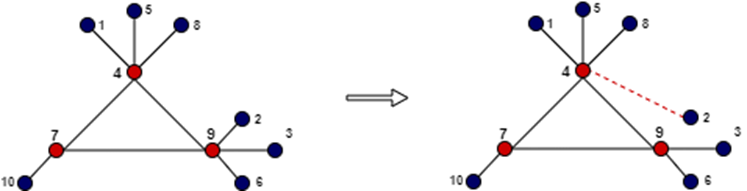

In [20]:
# Exploring neighbourhood structure 3

def NS3(current_solution, spoke):
    
    hubs = set(current_solution) # Set enlists unique elements of the array
    candidate_hubs = []
    
    new_solution = copy.deepcopy(current_solution)
    current_hub = new_solution[spoke-1] # Current hub of the spoke node which will later be replaced
    
    for hub in hubs:
        if hub != current_hub: # 
            candidate_hubs.append(hub) # Create a list of candidate hubs ignoring already allocated hub
    
    new_solution[spoke-1] = rd.choice(candidate_hubs) # Randomly select from candidate hubs
      
    return new_solution

In [21]:
# Generating a candidate solution with Steepest Descent Local Search Approach

def NS3_Steepest_Descent_Local_Search(current_solution, flow, cost):
    
    best_neighbourhood_solution = current_solution
    best_neighbourhood_cost = evaluate_total_cost(best_neighbourhood_solution, flow, cost)
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    # Evaluating costs for neighbourhoods created from list of spoke candidates
    for spoke in spokes:
        current_neighbourhood_solution = NS3(current_solution, spoke)
        current_neighbourhood_cost = evaluate_total_cost(current_neighbourhood_solution, flow, cost)
        # Compare costs of current solution with neighbourhood solution to select best neighbourhood
        if current_neighbourhood_cost < best_neighbourhood_cost:
            best_neighbourhood_solution = current_neighbourhood_solution
            best_neighbourhood_cost = current_neighbourhood_cost
            
    return best_neighbourhood_solution, best_neighbourhood_cost
    #return best_neighbourhood_solution

In [22]:
def NS3_Random_Local_Search(current_solution, flow, cost):
    
    spokes = [i for i in range(1, len(current_solution)+1) if i not in current_solution] 
    
    chosen_spoke = rd.choice(spokes)
    
    neighbourhood_solution = NS3(current_solution, chosen_spoke)
    neighbourhood_cost = evaluate_total_cost(neighbourhood_solution, flow, cost)
            
    return neighbourhood_solution, neighbourhood_cost

In [23]:
sample = [1, 1, 1, 4, 4, 4, 9, 9, 9, 9]

In [24]:
evaluate_total_cost(sample, flow, cost)

1159518519.55

In [25]:
NS3_Random_Local_Search(sample, flow, cost)

([1, 9, 1, 4, 4, 4, 9, 9, 9, 9], 1127330580.52)

## Structure 4: Swap spoke nodes allocation of two hubs with each other keeping hubs same  <a id='NS4'></a>

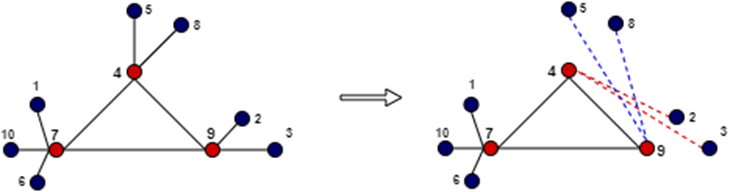

In [26]:
# Exploring neighbourhood structure 4

def NS4(current_solution, hub1, hub2):
        
    new_solution = copy.deepcopy(current_solution)
    
    # Spoke list created from 
    spoke_list1 =  [i for i in range(len(current_solution)) if current_solution[i] == hub1] 
    spoke_list2 =  [i for i in range(len(current_solution)) if current_solution[i] == hub2]
    
    for i in spoke_list1:
        if i != hub1-1:
            new_solution[i] = hub2
        
    for i in spoke_list2:
        if i != hub2-1:
            new_solution[i] = hub1

    return new_solution

In [27]:
# Generating a candidate solution with Steepest Descent Local Search Approach

def NS4_Steepest_Descent_Local_Search(current_solution, flow, cost):
    
    best_neighbourhood_solution = current_solution
    best_neighbourhood_cost = evaluate_total_cost(best_neighbourhood_solution, flow, cost)
    
    hubs = list(set(current_solution)) # Set enlists unique elements of the array
    
    # Evaluating costs for neighbourhoods created from list of spoke candidates
    for hub1 in hubs:
        for hub2 in hubs:
            current_neighbourhood_solution = NS4(current_solution, hub1, hub2)
            current_neighbourhood_cost = evaluate_total_cost(current_neighbourhood_solution, flow, cost)
            # Compare costs of current solution with neighbourhood solution to select best neighbourhood
            if current_neighbourhood_cost < best_neighbourhood_cost:
                best_neighbourhood_solution = current_neighbourhood_solution
                best_neighbourhood_cost = current_neighbourhood_cost
            
    return best_neighbourhood_solution, best_neighbourhood_cost
    #return best_neighbourhood_solution

In [28]:
def NS4_Random_Local_Search(current_solution, flow, cost):
    
    hubs = [i for i in range(1, len(current_solution)+1) if i in current_solution] 
    
    chosen_hub1 = rd.choice(hubs)
    chosen_hub2 = rd.choice(hubs)
    
    neighbourhood_solution = NS4(current_solution, chosen_hub1, chosen_hub2)
    neighbourhood_cost = evaluate_total_cost(neighbourhood_solution, flow, cost)
            
    return neighbourhood_solution, neighbourhood_cost

In [29]:
sample = [4, 7, 9, 4, 9, 9, 7, 7, 9, 4]

In [30]:
evaluate_total_cost(sample, flow, cost)

1013535885.42

In [31]:
NS4_Random_Local_Search(sample, flow, cost)

([7, 4, 9, 4, 9, 9, 7, 4, 9, 7], 834918414.16)

## Random Neighbourhood Selection <a id='NSF'></a>

In [32]:
# Defining a function to randomly choose the choice of steepest decent neighbourhood
def random_neighbourhood_selector(current_solution, flow, cost):  
    
    #neighbourhood_solution = current_solution.copy()
    options = ["NS1", "NS2", "NS3", "NS4"]   
    selected_neighbourhood_structure = rd.choice(options)
    
    if selected_neighbourhood_structure == "NS1":
        neighbourhood_solution, neighbourhood_cost = NS1_Random_Local_Search(current_solution, flow, cost)
    elif selected_neighbourhood_structure == "NS2":
        neighbourhood_solution, neighbourhood_cost = NS2_Random_Local_Search(current_solution, flow, cost)
    elif selected_neighbourhood_structure == "NS3":
        neighbourhood_solution, neighbourhood_cost = NS3_Random_Local_Search(current_solution, flow, cost)
    else:
        neighbourhood_solution, neighbourhood_cost = NS4_Random_Local_Search(current_solution, flow, cost)
    
    #print(selected_neighbourhood_structure)
    return neighbourhood_solution, neighbourhood_cost

In [33]:
sample = [4, 7, 9, 4, 9, 9, 7, 7, 9, 4]

In [34]:
random_neighbourhood_selector(sample, flow, cost)

([4, 7, 5, 4, 5, 5, 7, 7, 5, 4], 1077031767.62)

# Metaheuristics <a id='meta'></a>

## Simulated Annealing <a id='SA'></a>

In [35]:
# Defining a function for Non adaptive (cooling) Simulated Annealing Algorithm

def simulated_annealing(flow, cost, nodes, hubs, initial_temperature, cooling_factor, max_iterations):
    
    # Note start time of algorithm execution
    start = time.time()
        
    # Setting initial solution and temperature
    current_solution = initial_solution(nodes, hubs)
    current_temperature = initial_temperature
    current_cost = evaluate_total_cost(current_solution, flow, cost)
    
    # Iterating for given number of iterations
    for i in range(1, max_iterations + 1):
        
        # Generate a random neighbourhood solution as the candidate solution
        candidate_solution, candidate_cost = random_neighbourhood_selector(current_solution, flow, cost) # convert to random solution later
        
        # Compute the transition probability (probability of acceptance of candidate solution)
        transition_probability = np.exp(-(candidate_cost - current_cost) / current_temperature)
        
        # Accept the candidate solution if the candidate solution is better (lower cost)
        # Or accept a worse solution based on the transition probability which decreases as current_temperature increases
        # A random number between 0 and 1 is generated and candidate solution is accepted if transition porbability is higher
        if candidate_cost < current_cost or np.random.rand() < transition_probability:
            current_solution = candidate_solution
            
        # Calculate the current cost of the network
        current_cost = evaluate_total_cost(current_solution, flow, cost)
            
        # Decrease the temperature according to cooling factor parameter
        current_temperature *= cooling_factor
        
        # Print iteration number, current solution and current cost
        #print(f"\n For iteration {i} : Current Solution: {current_solution} and Current Network Cost: {current_cost}")
        
    # Note end time of algorithm execution
    end = time.time()
    
    # Current solution is the best solution after the specified number of iterations of the algorithm
    return current_solution, current_cost, round(end-start,2)

In [36]:
# Function Testing
# simulated_annealing(cab10_flow, cab10_cost, cab10_nodes, 3, 100, 0.99, 100)

## Variable Neighbourhood Descent <a id='VND'></a>

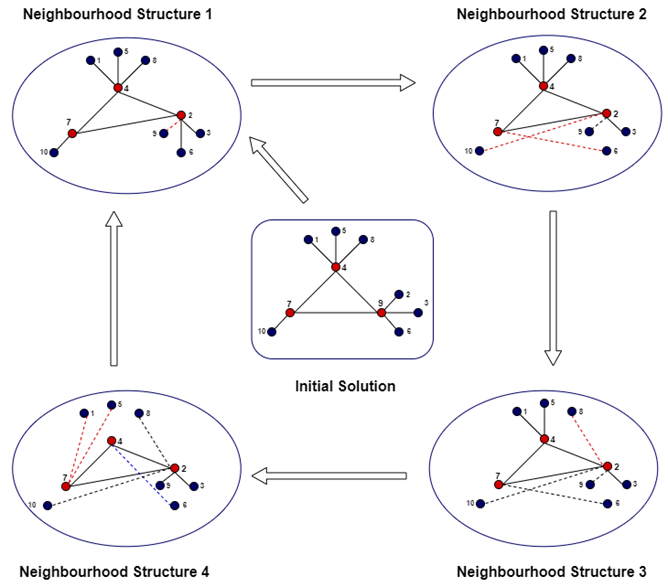

In [37]:
def variable_neighbourhood_search(flow, cost, nodes, hubs, max_iterations):

    # Note start time of algorithm execution
    start = time.time()
    
    # Setting initial solution
    current_solution = initial_solution(nodes, hubs)
    current_cost = evaluate_total_cost(current_solution, flow, cost)
    
    # Define list of neighbourhood structures available
    neighbourhoods = [NS1_Steepest_Descent_Local_Search, NS2_Steepest_Descent_Local_Search, NS3_Steepest_Descent_Local_Search, NS4_Steepest_Descent_Local_Search]
    
    # Start with the first neighbourhood structure
    k = 0
    iteration_number = 0
    
    while iteration_number < max_iterations:
        
        # Explore the neighbourhood of the current solution using the kth neighbourhood structure
        candidate_solution, candidate_cost = neighbourhoods[k](current_solution, flow, cost)
        iteration_number += 1
        
        # If a better neighbour is found, update the current solution and cost
        if candidate_cost < current_cost:
            current_solution = candidate_solution
            current_cost = candidate_cost
            k = 0
            
        else:
            k += 1
        
        # If all neighbourhood structures have been explored, start over with the first one
        if k >= len(neighbourhoods):
            k = 0

        # Print iteration number, current solution and current cost
        #print(f"\n Iteration: {iteration_number}, Current Solution: {current_solution} and Current Network Cost: {current_cost}")
            
    # Note start time of algorithm execution
    end = time.time()
    
    return current_solution, current_cost, round(end-start,2)

In [38]:
# Function Testing
# variable_neighbourhood_search(cab10_flow, cab10_cost, cab10_nodes, 3, 100)

## Iterative Execution of Selected Algorithm <a id='IE'></a>

<div class="alert alert-block alert-warning">
    
**NOTE:** 
    
Please note that the below function was earlier displaying "Best Network Results for Simulated Annealing:" for both the algorithms, this is a display error which was present during experimental analysis conducted for the basic execution. 
    
The function was fixed prior to conducting sensitivity analysis. Kindly refer to the function calls to verify the particular details passed to this function for iterative execution.
    
</div>

In [102]:
def iterative_computations(algorithm, flow, cost, nodes, hubs, max_iterations = 100, initial_temperature = 100, cooling_factor = 0.95):
    
    # Save results of each iteration in the below lists - to analyse average and best of 10 iterations
    network_cost = []
    execution_time = []
    network_solution = []
    
    # Run the algorithms for mentioned maximum number of iterations with 10 distinct initial solutions
    for i in range(10):
        
        # Check for selected algorithm - Simulated Annealing
        if algorithm == "Simulated Annealing":
            
            result = simulated_annealing(flow, cost, nodes, hubs, initial_temperature, cooling_factor, max_iterations)
            
            # Note down best cost, best solution and run time noted from algorithm after maximum number of iterations
            best_network = result[0]
            best_cost = result[1]
            run_time = result[2]
            
            # Append best cost, best solution and run time from current algorithm run
            network_solution.append(best_network)
            network_cost.append(best_cost)
            execution_time.append(run_time)
            
            # Print best cost, best solution, and run time achieved from current algorithm
            print(f"\n Best Network Results after {i+1} algorithm execution(s):")
            print(f"\n Best Network: {best_network}")
            print("\n Best Cost: ${:,.2f}".format(best_cost))
            print(f"\n Execution Time: {run_time} secs")
            print('\n')

        # Check for selected algorithm - Variable Neighbourhood Descent
        elif algorithm == "Variable Neighbourhood Descent":
            
            result = variable_neighbourhood_search(flow, cost, nodes, hubs, max_iterations)
            
            # Note down best cost, best solution and run time noted from algorithm after maximum number of iterations
            best_network = result[0]
            best_cost = result[1]
            run_time = result[2]
            
            # Append best cost, best solution and run time from current algorithm run
            network_solution.append(best_network)
            network_cost.append(best_cost)
            execution_time.append(run_time)
            
            # Print best cost, best solution, and run time achieved from current algorithm
            print(f"\n Best Network Results after {i+1} algorithm execution(s):")
            print(f"\n Best Network: {best_network}")
            print("\n Best Cost: ${:,.2f}".format(best_cost))
            print(f"\n Execution Time: {run_time} secs")
            print('\n')
        
        # Error Handling if incorrect algorithm selected
        else:
            print("Please choose a valid algorithm from Simulated Annealing or Variable Neighbourhood Descent")
    
    # Evaluate minimum (best) network cost and network solution from 10 iterative runs of the algorithm
    best_cost = min(network_cost)
    best_network = network_solution[network_cost.index(min(network_cost))]
    
    # Print Final Results of the alogirthm run for maximum number of iterations with 10 different initial solutions
    # Corrected below display code after experimental analysis prior to sensitivity analysis
    #print("\nBest Network Results for Simulated Annealing:")
    print(f"\nBest Network Results for {algorithm}:")
    print("Best Cost: ${:,.2f}".format(best_cost))
    print('Best Network:', best_network)
    print('Optimum Hubs:', set(best_network))
    print("Average Cost: ${:,.2f}".format(sum(network_cost)/10))
    print(f"Average Time: {round(sum(execution_time)/10,2)} secs")

# Implementation <a id='implement'></a>

<div class="alert alert-block alert-warning">
    
**NOTE:** 
    
Please note that the input file is an Excel workbook with each sheet containing details of the respective flow or cost matrix.
    
The Excel workbook can be viewed/ downloaded here: [Soft Computing Dataset Excel Workbook](https://github.com/Clarin19/hub-location-problem/blob/main/Soft%20Computing%20Validation%20Dataset.xlsx)
    
Select **View Raw** to download the Excel Workbook
    
</div>

## CAB 10 Nodes <a id='CAB10'></a>

In [40]:
# Read the passenger flow data for CAB10
cab10_flow, cab10_total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','CAB10 Flow')
print("The total demand of this network is:",total_flow)
cab10_flow

The total demand of this network is: 999026


,1,2,3,4,5,6,7,8,9,10
1,0,6469,7629,20036,4690,6194,11688,2243,8857,7248
2,6469,0,12999,13692,3322,5576,3878,3202,6699,4198
3,7629,12999,0,35135,5956,14121,5951,5768,16578,4242
4,20036,13692,35135,0,19094,35119,21423,27342,51341,15826
5,4690,3322,5956,19094,0,7284,3102,1562,7180,1917
6,6194,5576,14121,35119,7284,0,5023,3512,10419,3543
7,11688,3878,5951,21423,3102,5023,0,11557,6479,34261
8,2243,3202,5768,27342,1562,3512,11557,0,5615,7095
9,8857,6699,16578,51341,7180,10419,6479,5615,0,4448
10,7248,4198,4242,15826,1917,3543,34261,7095,4448,0


In [41]:
# Read the cost data for CAB10
cab10_cost = cost_matrix('Soft Computing Validation Dataset.xlsx','CAB10 Cost')
cab10_cost

,1,2,3,4,5,6,7,8,9,10
1,0.0000,576.9631,946.4954,597.5972,373.8127,559.7673,709.0215,1208.3280,603.6477,695.2080
2,576.9631,0.0000,369.5327,613.0386,429.1079,312.8831,1196.4890,1502.1400,405.8975,1241.9610
3,946.4954,369.5327,0.0000,858.3308,749.6018,556.0706,1541.2730,1764.7910,621.3306,1603.1650
4,597.5972,613.0386,858.3308,0.0000,255.0303,311.3071,790.1213,907.4331,237.0703,932.2173
5,373.8127,429.1079,749.6018,255.0303,0.0000,225.8954,794.1726,1080.3740,238.9440,879.5647
6,559.7673,312.8831,556.0706,311.3071,225.8954,0.0000,1009.6890,1216.8680,94.2588,1104.5740
7,709.0215,1196.4890,1541.2730,790.1213,794.1726,1009.6890,0.0000,663.8762,982.7378,221.4220
8,1208.3280,1502.1400,1764.7910,907.4331,1080.3740,1216.8680,663.8762,0.0000,1143.7910,874.5181
9,603.6477,405.8975,621.3306,237.0703,238.9440,94.2588,982.7378,1143.7910,0.0000,1094.9060
10,695.2080,1241.9610,1603.1650,932.2173,879.5647,1104.5740,221.4220,874.5181,1094.9060,0.0000


In [42]:
# Copy the node numbers allocated
cab10_nodes = list(cab10_flow.columns)
cab10_nodes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [43]:
# Declaring constants
p = 3 # Number of hubs
initial_temperature = 100 # For Simulated Annealing
cooling_factor = 0.99 # Cooling factor usually taken between 0.95 and 0.99
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [44]:
# Validating cost and network functions with test case provided
# 10 Node Test Case
cab10_sample = [4, 9, 9, 4, 4, 9, 7, 4, 9, 7]
cab10_total_cost = evaluate_total_cost(cab10_sample, cab10_flow, cab10_cost)
print("Total cost of the network is: ${:,.2f}".format(cab10_total_cost))

Total cost of the network is: $740,999,438.94


In [45]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", cab10_flow, cab10_cost, cab10_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [4, 6, 6, 4, 6, 6, 7, 4, 6, 7]

 Best Cost: $746,458,661.93

 Execution Time: 0.67 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 1, 4, 4, 4, 4, 1, 4, 4, 10]

 Best Cost: $940,152,709.07

 Execution Time: 0.63 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [4, 6, 6, 4, 4, 6, 7, 7, 6, 7]

 Best Cost: $756,344,042.94

 Execution Time: 0.7 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [4, 9, 9, 4, 4, 9, 7, 4, 9, 7]

 Best Cost: $740,999,438.94

 Execution Time: 0.68 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [9, 9, 9, 9, 5, 9, 7, 7, 9, 7]

 Best Cost: $790,423,034.60

 Execution Time: 0.63 secs



 Best Network Results after 6 algorithm execution(s):

 Best Network: [6, 2, 6, 4, 6, 6, 4, 6, 4, 4]

 Best Cost: $927,371,710.19

 Execution Time: 1.25 secs



 Best Network Results after 7 alg

In [46]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", cab10_flow, cab10_cost, cab10_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [5, 5, 4, 4, 5, 4, 4, 4, 4, 10]

 Best Cost: $898,475,866.26

 Execution Time: 1.46 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [9, 6, 6, 4, 6, 6, 4, 4, 9, 4]

 Best Cost: $845,446,733.77

 Execution Time: 1.45 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [6, 6, 6, 4, 5, 6, 4, 4, 6, 4]

 Best Cost: $832,584,838.48

 Execution Time: 1.7 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [5, 6, 6, 4, 5, 6, 4, 4, 5, 5]

 Best Cost: $867,074,694.82

 Execution Time: 1.47 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [4, 4, 6, 4, 4, 6, 7, 7, 4, 7]

 Best Cost: $784,041,079.68

 Execution Time: 1.21 secs



 Best Network Results after 6 algorithm execution(s):

 Best Network: [6, 6, 6, 4, 9, 6, 4, 4, 9, 9]

 Best Cost: $878,453,663.93

 Execution Time: 1.75 secs



 Best Network Results after 7 alg

## CAB 25 Nodes <a id='CAB25'></a>

In [47]:
# Read the passenger flow data for CAB25
cab25_flow, cab25_total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','CAB25 Flow')

In [48]:
# Read the cost data for CAB55
cab25_cost = cost_matrix('Soft Computing Validation Dataset.xlsx','CAB25 Cost')

In [49]:
# Copy the node numbers allocated
cab25_nodes = list(cab25_flow.columns)

In [50]:
# Declaring constants
p = 3 # Number of hubs
initial_temperature = 100 # For Simulated Annealing
cooling_factor = 0.99 # Cooling factor usually taken between 0.95 and 0.99
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [51]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", cab25_flow, cab25_cost, cab25_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [18, 18, 18, 4, 4, 4, 7, 4, 4, 4, 4, 7, 18, 18, 4, 7, 18, 18, 4, 18, 4, 7, 18, 18, 18]

 Best Cost: $10,326,781,978.51

 Execution Time: 9.46 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [5, 25, 25, 4, 5, 5, 4, 5, 4, 5, 4, 5, 4, 5, 25, 5, 25, 25, 4, 5, 4, 4, 4, 5, 25]

 Best Cost: $11,100,017,894.29

 Execution Time: 9.61 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [6, 18, 18, 4, 6, 6, 4, 4, 6, 4, 4, 4, 4, 18, 4, 6, 18, 18, 4, 6, 4, 6, 4, 6, 4]

 Best Cost: $11,015,487,020.41

 Execution Time: 9.55 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [1, 4, 17, 4, 4, 17, 1, 4, 4, 1, 4, 4, 1, 1, 4, 1, 17, 17, 4, 17, 4, 4, 4, 1, 4]

 Best Cost: $10,340,180,631.81

 Execution Time: 9.63 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [6, 25, 25, 6, 6, 6, 19, 6, 6, 19, 6, 19, 19, 25, 6, 6, 6, 25, 19,

In [52]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", cab25_flow, cab25_cost, cab25_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [4, 17, 17, 4, 17, 20, 20, 17, 4, 4, 20, 4, 4, 20, 4, 17, 17, 20, 4, 20, 4, 4, 20, 4, 17]

 Best Cost: $11,390,162,247.53

 Execution Time: 53.06 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [5, 5, 17, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 17, 17, 5, 5, 4, 4, 4, 4, 17]

 Best Cost: $10,453,688,153.59

 Execution Time: 72.45 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [1, 6, 6, 6, 6, 6, 6, 6, 6, 12, 6, 12, 1, 1, 6, 1, 6, 1, 12, 6, 1, 12, 12, 1, 1]

 Best Cost: $10,453,473,663.47

 Execution Time: 52.48 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [13, 13, 20, 4, 20, 20, 20, 4, 20, 13, 4, 13, 13, 20, 20, 4, 20, 4, 20, 20, 20, 4, 20, 4, 20]

 Best Cost: $12,075,711,965.72

 Execution Time: 52.48 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [20, 20, 20, 4, 4, 6, 4, 6, 6, 20, 6, 4, 4, 20, 

In [53]:
# Changing number of hubs to 5
p = 5

In [54]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", cab25_flow, cab25_cost, cab25_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [25, 25, 25, 5, 5, 5, 20, 5, 5, 5, 5, 5, 25, 20, 20, 25, 17, 20, 19, 20, 20, 5, 20, 17, 25]

 Best Cost: $11,815,359,500.47

 Execution Time: 10.18 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 17, 17, 4, 17, 20, 13, 4, 1, 13, 20, 13, 13, 1, 20, 4, 17, 17, 1, 20, 4, 4, 4, 1, 20]

 Best Cost: $10,535,039,392.24

 Execution Time: 10.53 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [20, 2, 2, 9, 20, 9, 13, 9, 9, 21, 13, 21, 13, 2, 9, 9, 2, 9, 20, 20, 21, 9, 21, 21, 2]

 Best Cost: $11,260,551,597.01

 Execution Time: 10.46 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [25, 25, 25, 4, 5, 5, 13, 13, 5, 13, 11, 5, 13, 5, 4, 13, 5, 4, 11, 4, 4, 4, 11, 13, 25]

 Best Cost: $11,883,318,513.03

 Execution Time: 10.3 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [11, 18, 9, 4, 4, 18, 7, 11, 9, 7, 

In [55]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", cab25_flow, cab25_cost, cab25_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [4, 18, 18, 4, 21, 18, 21, 4, 9, 11, 11, 21, 9, 18, 9, 4, 18, 18, 11, 9, 21, 4, 21, 9, 18]

 Best Cost: $10,478,175,910.17

 Execution Time: 47.98 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [20, 2, 2, 2, 20, 6, 8, 8, 20, 6, 8, 8, 2, 2, 6, 2, 2, 18, 8, 20, 20, 8, 6, 18, 2]

 Best Cost: $10,834,439,402.43

 Execution Time: 30.74 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [21, 21, 6, 6, 5, 6, 21, 5, 6, 21, 11, 11, 13, 13, 11, 13, 6, 6, 13, 5, 21, 11, 21, 13, 6]

 Best Cost: $11,242,950,442.93

 Execution Time: 69.16 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [1, 1, 17, 4, 17, 9, 9, 4, 9, 1, 9, 4, 1, 1, 4, 4, 17, 17, 4, 20, 20, 9, 9, 1, 17]

 Best Cost: $10,626,899,177.45

 Execution Time: 108.32 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [25, 25, 17, 5, 5, 5, 7, 21, 25, 7, 21, 7, 2

## TR 55 Nodes <a id='TR55'></a>

In [56]:
# Read the passenger flow data for TR55
tr55_flow, tr55_total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','TR55 Flow')

In [57]:
# Read the cost data for TR55
tr55_cost = cost_matrix('Soft Computing Validation Dataset.xlsx','TR55 Cost')

In [58]:
# Copy the node numbers allocated
tr55_nodes = list(tr55_flow.columns)

In [59]:
# Declaring constants
p = 3 # Number of hubs
initial_temperature = 100 # For Simulated Annealing
cooling_factor = 0.99 # Cooling factor usually taken between 0.95 and 0.99
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [60]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr55_flow, tr55_cost, tr55_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [34, 34, 4, 4, 30, 34, 4, 30, 34, 4, 4, 4, 30, 4, 34, 30, 34, 30, 34, 4, 34, 34, 34, 4, 4, 30, 30, 4, 4, 30, 4, 34, 4, 34, 4, 34, 4, 30, 4, 4, 34, 34, 34, 34, 4, 34, 4, 34, 30, 34, 4, 30, 30, 34, 30]

 Best Cost: $34,069,635,201.60

 Execution Time: 40.96 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [28, 8, 37, 8, 8, 37, 8, 8, 28, 8, 28, 28, 8, 37, 37, 8, 28, 8, 8, 37, 37, 8, 28, 8, 28, 8, 8, 28, 8, 8, 8, 37, 37, 8, 8, 37, 37, 8, 37, 8, 8, 28, 37, 8, 8, 37, 8, 37, 28, 37, 8, 8, 8, 37, 28]

 Best Cost: $43,253,048,129.80

 Execution Time: 40.33 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [29, 45, 29, 29, 8, 45, 8, 8, 29, 45, 8, 29, 29, 29, 29, 45, 45, 29, 45, 45, 45, 45, 45, 45, 45, 8, 8, 29, 29, 29, 45, 8, 8, 29, 29, 8, 29, 45, 8, 8, 29, 29, 45, 8, 45, 29, 45, 29, 45, 45, 8, 29, 29, 8, 45]

 Best Cost: $38,053,112,429.80

 Execution Time: 40.71 secs


In [61]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr55_flow, tr55_cost, tr55_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [31, 31, 4, 4, 31, 4, 31, 25, 4, 25, 4, 4, 4, 4, 31, 31, 25, 4, 4, 4, 25, 25, 4, 25, 25, 4, 4, 31, 25, 4, 31, 4, 31, 25, 25, 4, 4, 25, 4, 31, 25, 25, 4, 4, 25, 4, 25, 4, 4, 31, 4, 4, 4, 4, 31]

 Best Cost: $38,843,774,623.60

 Execution Time: 1684.21 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [45, 31, 30, 45, 31, 31, 30, 30, 45, 30, 30, 30, 30, 30, 45, 31, 45, 45, 45, 30, 31, 45, 45, 31, 45, 30, 30, 45, 31, 30, 31, 31, 31, 30, 31, 30, 45, 45, 45, 30, 31, 31, 31, 31, 45, 31, 30, 31, 45, 31, 31, 30, 30, 30, 30]

 Best Cost: $37,370,651,703.20

 Execution Time: 1175.0 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [4, 28, 28, 4, 30, 28, 30, 28, 4, 4, 4, 30, 30, 28, 28, 28, 30, 4, 28, 28, 30, 28, 4, 4, 4, 30, 30, 28, 28, 30, 28, 4, 28, 4, 4, 28, 4, 28, 30, 4, 30, 28, 30, 30, 4, 30, 28, 30, 28, 28, 28, 28, 30, 28, 4]

 Best Cost: $36,933,762,983.40

 Execu

In [62]:
# Changing number of hubs to 5
p = 5

In [63]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr55_flow, tr55_cost, tr55_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 26, 1, 4, 53, 1, 26, 1, 1, 26, 26, 26, 53, 53, 1, 53, 24, 24, 4, 1, 26, 1, 1, 24, 26, 26, 24, 4, 53, 26, 4, 24, 24, 1, 1, 4, 4, 1, 1, 53, 4, 1, 24, 53, 24, 24, 1, 1, 53, 53, 24, 4, 53, 53, 24]

 Best Cost: $37,512,031,057.60

 Execution Time: 17.19 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [45, 4, 4, 4, 4, 4, 45, 4, 29, 4, 40, 4, 4, 4, 40, 29, 4, 4, 45, 40, 4, 45, 4, 47, 47, 40, 45, 47, 29, 4, 47, 47, 4, 45, 29, 29, 4, 29, 4, 40, 40, 45, 29, 4, 45, 47, 47, 29, 4, 4, 45, 4, 40, 29, 47]

 Best Cost: $41,366,280,298.20

 Execution Time: 16.97 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [1, 42, 18, 4, 18, 42, 12, 42, 1, 42, 1, 12, 18, 12, 18, 18, 18, 18, 42, 1, 42, 1, 4, 1, 1, 12, 18, 4, 12, 12, 42, 12, 4, 4, 1, 42, 4, 42, 12, 12, 42, 42, 4, 12, 18, 18, 18, 4, 42, 42, 42, 1, 4, 42, 1]

 Best Cost: $37,469,641,041.20

 Execution Time: 16.76 secs




In [64]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr55_flow, tr55_cost, tr55_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [31, 12, 26, 4, 12, 26, 26, 29, 26, 26, 29, 12, 29, 4, 4, 26, 29, 4, 4, 31, 12, 29, 29, 29, 31, 26, 26, 4, 29, 12, 31, 31, 12, 31, 4, 4, 26, 29, 26, 26, 31, 4, 31, 29, 4, 31, 26, 31, 29, 4, 12, 12, 12, 12, 12]

 Best Cost: $38,432,975,626.00

 Execution Time: 446.29 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 5, 4, 4, 5, 30, 12, 30, 12, 12, 4, 12, 1, 30, 1, 5, 30, 1, 1, 5, 1, 5, 1, 30, 1, 30, 30, 4, 12, 30, 4, 12, 4, 1, 1, 1, 4, 30, 4, 30, 5, 1, 12, 5, 4, 12, 30, 1, 4, 5, 1, 30, 4, 1, 1]

 Best Cost: $34,062,071,893.00

 Execution Time: 641.27 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [28, 4, 30, 4, 4, 28, 30, 45, 30, 34, 34, 4, 4, 4, 28, 30, 45, 28, 34, 28, 4, 30, 28, 45, 45, 30, 30, 28, 4, 30, 4, 34, 4, 34, 45, 34, 28, 4, 4, 30, 28, 34, 45, 28, 45, 45, 28, 34, 4, 4, 4, 34, 34, 4, 34]

 Best Cost: $34,597,105,399.00

 Execution Time: 440.57 s

## TR 81 Nodes <a id='TR81'></a>

In [65]:
# Read the passenger flow data for TR55
tr81_flow, tr81_total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','TR81 Flow')

In [66]:
# Read the cost data for TR55
tr81_cost = cost_matrix('Soft Computing Validation Dataset.xlsx','TR81 Cost')

In [67]:
# Copy the node numbers allocated
tr81_nodes = list(tr81_flow.columns)

In [68]:
# Declaring constants
p = 5 # Number of hubs
initial_temperature = 100 # For Simulated Annealing
cooling_factor = 0.99 # Cooling factor usually taken between 0.95 and 0.99
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [69]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr81_flow, tr81_cost, tr81_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [42, 47, 17, 47, 10, 42, 10, 47, 10, 10, 54, 10, 47, 10, 10, 17, 17, 17, 54, 54, 42, 54, 47, 47, 47, 17, 47, 47, 17, 47, 10, 42, 10, 54, 10, 47, 17, 54, 42, 10, 10, 42, 47, 42, 54, 47, 47, 17, 42, 42, 17, 17, 47, 54, 47, 47, 10, 54, 17, 17, 42, 42, 42, 10, 47, 17, 42, 47, 54, 42, 42, 54, 17, 42, 42, 47, 10, 17, 47, 42, 10]

 Best Cost: $80,146,521,623.17

 Execution Time: 97.57 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [6, 42, 6, 42, 68, 6, 45, 68, 45, 10, 6, 10, 42, 45, 68, 6, 42, 68, 42, 10, 6, 68, 6, 6, 68, 10, 42, 68, 10, 68, 68, 6, 42, 10, 45, 68, 42, 68, 6, 6, 10, 42, 10, 6, 45, 68, 10, 45, 68, 68, 6, 6, 42, 68, 6, 10, 10, 45, 68, 6, 68, 42, 42, 45, 10, 10, 68, 68, 45, 68, 42, 10, 42, 42, 45, 10, 68, 68, 42, 42, 10]

 Best Cost: $73,436,809,124.51

 Execution Time: 97.82 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [40, 5, 71, 5, 5, 71, 71, 7

In [70]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr81_flow, tr81_cost, tr81_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [46, 6, 6, 46, 81, 6, 6, 81, 6, 81, 81, 54, 46, 6, 54, 54, 40, 40, 81, 54, 46, 40, 40, 6, 40, 40, 40, 6, 40, 46, 46, 81, 6, 54, 54, 54, 54, 54, 6, 40, 81, 40, 54, 81, 81, 46, 40, 40, 46, 81, 40, 54, 54, 54, 54, 40, 81, 6, 6, 54, 46, 46, 40, 40, 40, 40, 81, 6, 54, 54, 54, 81, 40, 6, 46, 81, 40, 6, 54, 54, 81]

 Best Cost: $66,102,308,141.74

 Execution Time: 3954.96 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [38, 68, 6, 38, 6, 6, 54, 38, 54, 54, 68, 81, 54, 68, 68, 6, 81, 81, 6, 6, 6, 38, 68, 68, 6, 6, 38, 38, 54, 54, 68, 81, 38, 54, 54, 6, 6, 38, 54, 38, 81, 6, 81, 38, 38, 38, 54, 81, 81, 54, 81, 6, 81, 54, 54, 68, 54, 38, 6, 54, 81, 81, 68, 38, 54, 54, 6, 68, 54, 68, 38, 38, 38, 81, 54, 54, 68, 81, 81, 38, 81]

 Best Cost: $67,864,912,416.68

 Execution Time: 2184.87 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [40, 38, 54, 6, 54, 6, 38, 6, 54, 6, 

In [71]:
# Changing number of hubs to 7
p = 7

In [72]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr81_flow, tr81_cost, tr81_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [41, 25, 41, 25, 41, 40, 7, 47, 41, 42, 7, 40, 47, 7, 42, 42, 42, 42, 42, 41, 41, 40, 25, 47, 25, 42, 40, 25, 25, 25, 7, 25, 40, 41, 41, 47, 7, 40, 40, 40, 41, 42, 25, 41, 42, 71, 47, 25, 42, 40, 71, 71, 42, 40, 41, 40, 7, 25, 47, 7, 40, 7, 47, 71, 47, 7, 41, 71, 47, 7, 71, 40, 7, 42, 47, 42, 71, 40, 25, 40, 42]

 Best Cost: $77,571,854,118.16

 Execution Time: 47.68 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [40, 46, 40, 65, 71, 40, 7, 71, 71, 43, 43, 46, 71, 43, 43, 71, 79, 40, 71, 71, 46, 40, 79, 71, 43, 40, 40, 46, 65, 46, 79, 79, 79, 43, 43, 46, 79, 40, 71, 40, 65, 40, 43, 40, 7, 46, 79, 40, 46, 65, 65, 46, 79, 7, 43, 40, 46, 43, 46, 79, 79, 71, 71, 7, 65, 71, 71, 40, 46, 40, 71, 79, 40, 79, 79, 71, 65, 79, 79, 46, 46]

 Best Cost: $78,054,546,060.25

 Execution Time: 47.84 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [3, 31, 3, 41, 31, 34, 41,

In [73]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr81_flow, tr81_cost, tr81_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [6, 38, 42, 40, 54, 6, 54, 40, 54, 42, 38, 42, 40, 14, 54, 54, 45, 40, 38, 42, 40, 54, 42, 38, 6, 14, 38, 6, 42, 42, 38, 42, 54, 54, 45, 54, 45, 38, 45, 40, 14, 42, 38, 54, 45, 6, 38, 54, 38, 40, 38, 54, 54, 54, 14, 14, 40, 14, 14, 40, 38, 42, 40, 54, 40, 40, 40, 40, 6, 38, 38, 6, 38, 38, 42, 40, 40, 38, 45, 42, 45]

 Best Cost: $64,026,398,738.67

 Execution Time: 1438.94 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [6, 14, 71, 66, 40, 6, 6, 14, 40, 71, 40, 40, 6, 14, 40, 34, 34, 18, 6, 6, 6, 18, 6, 14, 14, 40, 66, 34, 34, 40, 71, 6, 6, 34, 6, 34, 40, 71, 66, 40, 14, 34, 6, 40, 18, 6, 66, 6, 6, 71, 71, 71, 6, 40, 6, 66, 18, 34, 34, 40, 71, 14, 14, 71, 18, 66, 18, 40, 71, 6, 71, 40, 34, 66, 66, 40, 66, 14, 40, 34, 6]

 Best Cost: $71,369,703,030.96

 Execution Time: 1448.87 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [40, 43, 3, 71, 18, 6, 3, 40, 3, 

## RGP 100 Nodes <a id='RGP100'></a>

In [74]:
# Read the passenger flow data for TR55
rgp100_flow, rgp100_total_flow = flow_matrix('Soft Computing Validation Dataset.xlsx','RGP100 Flow')

In [75]:
# Read the cost data for TR55
rgp100_cost = cost_matrix('Soft Computing Validation Dataset.xlsx','RGP100 Cost')

In [76]:
# Copy the node numbers allocated
rgp100_nodes = list(rgp100_flow.columns)

In [77]:
# Declaring constants
p = 7 # Number of hubs
initial_temperature = 100 # For Simulated Annealing
cooling_factor = 0.99 # Cooling factor usually taken between 0.95 and 0.99
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [78]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", rgp100_flow, rgp100_cost, rgp100_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [33, 45, 45, 26, 81, 81, 66, 81, 66, 81, 81, 26, 100, 81, 45, 45, 65, 26, 33, 26, 26, 26, 26, 45, 81, 26, 33, 33, 33, 81, 65, 100, 33, 81, 26, 26, 33, 100, 33, 26, 45, 81, 26, 100, 45, 100, 45, 26, 81, 33, 45, 65, 45, 33, 33, 26, 33, 33, 45, 45, 81, 100, 33, 100, 65, 66, 66, 26, 33, 45, 26, 45, 81, 33, 65, 66, 66, 100, 100, 26, 81, 100, 45, 65, 81, 26, 33, 66, 66, 81, 33, 66, 45, 100, 66, 26, 65, 65, 33, 100]

 Best Cost: $155,797,333,960.38

 Execution Time: 172.51 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [5, 38, 20, 20, 5, 5, 5, 53, 9, 20, 77, 9, 53, 20, 53, 91, 77, 38, 91, 20, 38, 53, 20, 38, 91, 9, 9, 20, 53, 53, 53, 9, 9, 91, 53, 77, 20, 38, 20, 38, 77, 9, 77, 38, 9, 53, 5, 9, 9, 20, 9, 5, 53, 91, 9, 9, 91, 77, 9, 38, 91, 91, 53, 53, 91, 38, 77, 38, 38, 91, 77, 77, 91, 20, 91, 91, 77, 9, 91, 53, 9, 20, 53, 53, 38, 38, 77, 20, 91, 9, 91, 38, 38, 20, 20, 9, 77, 38, 77, 5]

 Be

In [79]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", rgp100_flow, rgp100_cost, rgp100_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [59, 3, 3, 59, 80, 54, 90, 8, 68, 80, 59, 59, 80, 54, 3, 80, 90, 68, 54, 68, 54, 59, 68, 80, 68, 54, 59, 54, 80, 59, 3, 90, 3, 3, 3, 8, 8, 54, 59, 90, 54, 68, 90, 90, 90, 68, 54, 3, 3, 8, 68, 54, 8, 54, 80, 59, 59, 90, 59, 8, 80, 8, 3, 3, 8, 90, 90, 68, 59, 80, 8, 3, 54, 68, 80, 68, 59, 80, 8, 80, 8, 54, 3, 54, 54, 80, 80, 90, 3, 90, 3, 8, 54, 3, 59, 3, 90, 3, 80, 8]

 Best Cost: $156,619,379,720.40

 Execution Time: 815.95 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 76, 76, 5, 5, 7, 7, 21, 21, 35, 18, 76, 18, 1, 5, 76, 5, 18, 5, 5, 21, 5, 1, 21, 5, 1, 5, 76, 1, 18, 18, 76, 1, 7, 35, 1, 7, 5, 5, 1, 5, 1, 76, 21, 1, 21, 7, 21, 21, 76, 18, 76, 1, 76, 1, 76, 1, 1, 1, 5, 76, 76, 1, 76, 1, 76, 35, 5, 7, 35, 1, 76, 35, 1, 35, 76, 21, 1, 1, 18, 5, 76, 18, 76, 76, 76, 21, 35, 18, 76, 35, 5, 5, 18, 7, 21, 76, 7, 76, 21]

 Best Cost: $153,025,720,561.91

 Execution Time: 6730.07 secs



 

In [80]:
# Changing number of hubs to 10
p = 10

In [81]:
# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", rgp100_flow, rgp100_cost, rgp100_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [79, 49, 96, 72, 72, 79, 74, 53, 49, 96, 76, 72, 43, 68, 74, 76, 43, 74, 68, 53, 43, 68, 68, 43, 72, 53, 79, 72, 76, 49, 53, 72, 74, 74, 79, 74, 68, 74, 43, 53, 74, 68, 43, 74, 43, 60, 49, 79, 49, 76, 72, 60, 53, 96, 68, 60, 74, 74, 43, 60, 68, 76, 79, 68, 43, 76, 60, 68, 74, 79, 53, 72, 60, 74, 96, 76, 43, 53, 79, 96, 49, 74, 96, 53, 96, 53, 43, 43, 74, 68, 53, 43, 43, 72, 74, 96, 72, 74, 49, 53]

 Best Cost: $153,801,694,170.70

 Execution Time: 73.54 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [6, 2, 6, 20, 2, 6, 33, 33, 66, 23, 2, 23, 40, 20, 20, 65, 57, 57, 40, 20, 2, 65, 23, 57, 58, 2, 40, 33, 66, 57, 65, 2, 33, 58, 23, 57, 57, 6, 40, 40, 58, 20, 66, 66, 33, 65, 23, 23, 58, 23, 20, 40, 20, 23, 58, 20, 57, 58, 57, 58, 40, 57, 58, 65, 65, 66, 57, 6, 58, 33, 57, 65, 40, 57, 6, 33, 6, 2, 66, 2, 33, 23, 20, 2, 57, 20, 66, 23, 58, 40, 2, 57, 2, 2, 65, 65, 40, 58, 58, 2]

 Best Cost:

In [82]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", rgp100_flow, rgp100_cost, rgp100_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [73, 58, 58, 58, 67, 58, 67, 60, 64, 67, 58, 79, 67, 67, 73, 64, 67, 60, 67, 58, 67, 70, 79, 67, 45, 45, 70, 58, 44, 45, 45, 79, 73, 67, 79, 70, 67, 70, 40, 40, 70, 64, 60, 44, 45, 45, 60, 64, 70, 40, 45, 70, 67, 64, 67, 73, 40, 58, 58, 60, 60, 60, 58, 64, 40, 67, 67, 64, 67, 70, 60, 67, 73, 73, 58, 40, 45, 70, 79, 73, 67, 40, 73, 73, 70, 60, 79, 58, 40, 64, 44, 58, 60, 45, 44, 64, 73, 67, 70, 60]

 Best Cost: $152,507,970,612.97

 Execution Time: 6812.35 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 59, 60, 25, 76, 27, 32, 59, 1, 77, 77, 77, 36, 25, 77, 76, 17, 1, 27, 59, 1, 60, 77, 1, 25, 60, 27, 32, 27, 59, 1, 32, 36, 60, 17, 36, 76, 27, 17, 60, 25, 32, 60, 17, 17, 1, 60, 60, 25, 59, 27, 32, 27, 60, 25, 36, 76, 60, 59, 60, 1, 76, 76, 1, 59, 76, 77, 17, 27, 59, 77, 36, 76, 27, 77, 76, 77, 27, 60, 1, 59, 36, 25, 32, 27, 17, 77, 36, 59, 1, 60, 25, 59, 77, 1, 17, 36, 17, 1, 25]

 B

# Sensitivity Analysis <a id='Sen'></a>

## Simulated Annealing: Reducing Cooling Factor <a id='Sen1'></a>

In [99]:
# Declaring constants
initial_temperature = 100 # For Simulated Annealing
SA_max_iterations = 100 # Maximum number of algorithm iterations for SA
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

# Changing the cooling factor to 0.95
cooling_factor = 0.95 # Cooling factor usually taken between 0.95 and 0.99

In [100]:
# Setting the number of hubs
p = 3

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", cab25_flow, cab25_cost, cab25_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [5, 17, 17, 5, 5, 5, 5, 21, 21, 5, 5, 21, 21, 17, 21, 21, 17, 5, 17, 5, 21, 21, 21, 17, 17]

 Best Cost: $11,103,020,845.82

 Execution Time: 9.59 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [5, 18, 18, 5, 5, 18, 18, 5, 18, 24, 5, 5, 5, 24, 5, 24, 18, 18, 5, 18, 18, 5, 5, 24, 18]

 Best Cost: $11,361,941,320.43

 Execution Time: 9.65 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [13, 2, 2, 4, 2, 4, 4, 4, 4, 13, 4, 13, 13, 2, 4, 13, 2, 2, 13, 2, 4, 13, 4, 13, 2]

 Best Cost: $10,316,393,908.67

 Execution Time: 10.11 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [21, 25, 25, 21, 21, 21, 21, 21, 25, 21, 21, 12, 25, 25, 21, 21, 25, 25, 12, 25, 21, 12, 12, 25, 25]

 Best Cost: $8,717,284,802.74

 Execution Time: 9.62 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [6, 17, 17, 6, 17, 6, 6, 22, 6

In [101]:
# Setting the number of hubs
p = 5

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", cab25_flow, cab25_cost, cab25_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 17, 17, 4, 5, 4, 4, 13, 17, 13, 4, 4, 13, 13, 17, 4, 17, 1, 13, 17, 5, 4, 4, 1, 17]

 Best Cost: $11,315,941,126.65

 Execution Time: 10.43 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [17, 4, 17, 4, 24, 17, 4, 4, 17, 24, 21, 12, 21, 24, 4, 24, 17, 4, 4, 4, 21, 4, 21, 24, 4]

 Best Cost: $10,904,237,713.42

 Execution Time: 10.3 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [1, 18, 3, 6, 1, 6, 1, 10, 18, 10, 1, 10, 1, 1, 18, 18, 18, 18, 10, 6, 1, 1, 18, 1, 18]

 Best Cost: $11,461,693,319.29

 Execution Time: 10.3 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [1, 5, 17, 4, 5, 5, 20, 5, 4, 1, 5, 4, 1, 1, 4, 1, 17, 20, 4, 20, 5, 4, 4, 1, 17]

 Best Cost: $10,308,697,499.55

 Execution Time: 10.53 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [6, 6, 6, 6, 21, 6, 21, 21, 6, 10, 21, 12, 14,

In [86]:
# Setting the number of hubs
p = 3

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr55_flow, tr55_cost, tr55_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 1, 18, 18, 18, 15, 18, 1, 1, 15, 18, 18, 1, 18, 15, 18, 1, 18, 1, 1, 18, 15, 1, 15, 1, 18, 18, 1, 18, 18, 18, 18, 18, 1, 1, 1, 18, 15, 15, 18, 1, 15, 15, 1, 1, 1, 1, 1, 1, 15, 18, 18, 18, 15, 1]

 Best Cost: $35,790,730,281.00

 Execution Time: 16.22 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [4, 4, 4, 4, 30, 30, 4, 30, 4, 14, 30, 30, 30, 14, 14, 30, 4, 4, 4, 14, 4, 14, 4, 14, 30, 30, 4, 14, 30, 30, 4, 14, 14, 30, 4, 14, 4, 4, 14, 14, 4, 4, 4, 30, 30, 4, 30, 4, 14, 30, 14, 14, 4, 14, 14]

 Best Cost: $40,141,727,709.80

 Execution Time: 15.41 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [55, 29, 55, 29, 32, 55, 29, 55, 55, 32, 55, 32, 32, 32, 55, 55, 55, 32, 55, 55, 29, 32, 55, 29, 32, 29, 32, 29, 29, 29, 29, 32, 55, 29, 29, 55, 29, 32, 29, 32, 29, 55, 55, 32, 29, 29, 32, 55, 29, 55, 55, 32, 29, 55, 55]

 Best Cost: $42,619,242,142.00

 Executio

In [88]:
# Setting the number of hubs
p = 5

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr55_flow, tr55_cost, tr55_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 1, 1, 4, 32, 4, 4, 32, 45, 44, 32, 44, 45, 4, 4, 1, 1, 32, 45, 4, 45, 32, 1, 44, 45, 32, 44, 4, 1, 4, 32, 32, 32, 45, 1, 44, 45, 4, 32, 45, 32, 45, 45, 44, 45, 45, 45, 1, 44, 32, 44, 4, 4, 44, 1]

 Best Cost: $39,732,192,365.80

 Execution Time: 16.7 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [54, 14, 54, 14, 54, 15, 14, 15, 44, 31, 31, 44, 31, 14, 15, 31, 54, 31, 54, 14, 14, 31, 31, 31, 31, 44, 31, 14, 54, 14, 31, 44, 31, 31, 15, 15, 14, 14, 14, 44, 14, 14, 31, 44, 31, 15, 44, 15, 14, 15, 54, 44, 44, 54, 14]

 Best Cost: $41,170,019,965.60

 Execution Time: 29.91 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [4, 25, 25, 4, 8, 8, 8, 8, 14, 14, 37, 14, 8, 14, 25, 25, 14, 14, 25, 37, 25, 14, 8, 25, 25, 8, 14, 25, 4, 8, 8, 4, 4, 14, 25, 14, 37, 25, 37, 37, 14, 25, 14, 37, 37, 4, 25, 25, 4, 25, 37, 25, 4, 37, 14]

 Best Cost: $42,036,645,629.00

 Exe

In [89]:
# Setting the number of hubs
p = 5

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr81_flow, tr81_cost, tr81_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [62, 67, 34, 34, 62, 34, 62, 44, 62, 67, 42, 62, 44, 62, 67, 34, 42, 34, 44, 67, 42, 67, 62, 67, 44, 42, 62, 44, 44, 62, 62, 67, 42, 34, 42, 44, 42, 44, 44, 42, 44, 42, 42, 44, 42, 44, 44, 62, 34, 42, 44, 34, 42, 42, 67, 44, 34, 44, 67, 42, 44, 62, 62, 42, 62, 42, 67, 42, 44, 42, 67, 44, 44, 67, 62, 67, 67, 62, 34, 42, 67]

 Best Cost: $81,394,355,700.59

 Execution Time: 97.08 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [54, 27, 18, 18, 78, 78, 54, 54, 70, 70, 18, 78, 27, 54, 78, 78, 27, 18, 18, 70, 70, 78, 27, 70, 18, 54, 27, 18, 78, 70, 78, 27, 70, 54, 54, 18, 70, 78, 54, 18, 78, 78, 54, 27, 54, 70, 27, 78, 27, 54, 27, 18, 70, 54, 18, 27, 18, 18, 54, 54, 18, 54, 27, 78, 18, 54, 54, 27, 18, 70, 78, 70, 70, 78, 54, 54, 18, 78, 27, 27, 27]

 Best Cost: $71,834,892,660.76

 Execution Time: 97.63 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [40, 80, 40

In [90]:
# Setting the number of hubs
p = 7

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", tr81_flow, tr81_cost, tr81_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [2, 2, 3, 34, 5, 3, 3, 52, 2, 58, 11, 11, 34, 5, 11, 34, 3, 34, 5, 5, 58, 3, 58, 34, 58, 58, 58, 3, 2, 34, 11, 11, 52, 34, 11, 2, 3, 58, 11, 58, 5, 5, 58, 5, 3, 5, 52, 5, 11, 58, 5, 52, 58, 3, 5, 34, 34, 58, 2, 5, 58, 2, 2, 3, 2, 11, 11, 3, 5, 52, 58, 58, 52, 58, 2, 58, 5, 34, 2, 5, 52]

 Best Cost: $74,794,631,978.70

 Execution Time: 106.35 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [71, 51, 3, 72, 41, 19, 3, 53, 51, 41, 71, 41, 53, 3, 3, 19, 41, 53, 19, 3, 19, 19, 41, 71, 72, 41, 3, 19, 71, 53, 51, 41, 72, 41, 19, 71, 19, 3, 19, 71, 41, 19, 71, 19, 41, 3, 72, 3, 71, 51, 51, 41, 53, 72, 51, 71, 41, 3, 41, 41, 71, 71, 19, 3, 41, 71, 41, 72, 53, 72, 71, 72, 71, 19, 19, 19, 41, 71, 19, 72, 41]

 Best Cost: $78,033,202,599.02

 Execution Time: 103.63 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [51, 43, 3, 51, 66, 34, 3, 51, 3, 43, 11, 43, 66, 66, 51,

In [91]:
# Setting the number of hubs
p = 7

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", rgp100_flow, rgp100_cost, rgp100_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [19, 19, 49, 76, 16, 76, 76, 19, 19, 35, 19, 76, 76, 19, 19, 16, 19, 49, 19, 72, 76, 72, 24, 24, 16, 49, 24, 16, 35, 19, 24, 49, 19, 76, 35, 35, 16, 16, 24, 19, 72, 76, 72, 24, 72, 19, 49, 49, 49, 76, 49, 19, 35, 24, 19, 19, 49, 49, 16, 49, 16, 19, 24, 49, 24, 76, 16, 35, 35, 24, 16, 72, 19, 72, 35, 76, 72, 49, 16, 24, 49, 19, 76, 72, 35, 49, 76, 24, 35, 24, 16, 49, 16, 19, 76, 76, 76, 72, 19, 19]

 Best Cost: $158,092,820,619.18

 Execution Time: 173.88 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [22, 60, 95, 58, 95, 54, 60, 47, 54, 47, 54, 22, 60, 58, 47, 58, 58, 95, 32, 32, 54, 22, 60, 58, 60, 95, 22, 32, 54, 95, 95, 32, 47, 95, 58, 60, 22, 60, 95, 32, 32, 60, 60, 54, 54, 22, 47, 95, 95, 58, 95, 54, 22, 54, 22, 95, 95, 58, 47, 60, 60, 32, 58, 22, 22, 22, 32, 47, 22, 58, 95, 32, 22, 54, 47, 47, 22, 22, 60, 22, 95, 95, 95, 95, 54, 60, 22, 95, 95, 54, 58, 47, 32, 58, 95, 22, 58, 47,

In [92]:
# Setting the number of hubs
p = 10

# Run the Simulated Algorithm for 10 different initial solution
iterative_computations("Simulated Annealing", rgp100_flow, rgp100_cost, rgp100_nodes, p, SA_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [26, 40, 26, 18, 17, 9, 88, 23, 9, 26, 63, 23, 40, 23, 15, 40, 17, 18, 17, 17, 17, 26, 23, 23, 26, 26, 63, 88, 26, 26, 18, 88, 88, 26, 17, 15, 9, 40, 18, 40, 18, 88, 9, 17, 9, 18, 17, 9, 15, 77, 17, 63, 9, 63, 15, 40, 17, 17, 63, 9, 26, 23, 63, 40, 9, 63, 40, 17, 88, 40, 88, 88, 9, 88, 23, 26, 77, 26, 40, 77, 17, 77, 18, 17, 77, 17, 26, 88, 26, 23, 9, 26, 40, 26, 63, 23, 40, 63, 17, 9]

 Best Cost: $152,073,042,273.74

 Execution Time: 194.75 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [38, 3, 3, 77, 77, 3, 91, 3, 91, 94, 77, 77, 77, 34, 38, 61, 34, 38, 3, 95, 57, 34, 3, 34, 91, 57, 38, 94, 91, 38, 95, 95, 77, 34, 38, 61, 94, 38, 95, 94, 38, 95, 34, 94, 77, 95, 38, 95, 89, 34, 57, 94, 38, 91, 94, 3, 57, 3, 95, 3, 61, 94, 95, 57, 3, 94, 61, 3, 61, 38, 77, 94, 61, 94, 89, 3, 77, 91, 89, 3, 89, 38, 89, 89, 77, 94, 77, 3, 89, 61, 91, 38, 95, 94, 95, 77, 61, 94, 57, 38]

 Best Cost: $154

## Variable Neighbourhood Descent: Reducing Maximum Neighbourhood Searched <a id='Sen2'></a>

In [103]:
# Redefine the variable neighbourhood structure algorithm to only consider two neighbourhood structures

def variable_neighbourhood_search(flow, cost, nodes, hubs, max_iterations):

    # Note start time of algorithm execution
    start = time.time()
    
    # Setting initial solution
    current_solution = initial_solution(nodes, hubs)
    current_cost = evaluate_total_cost(current_solution, flow, cost)
    
    # Define list of neighbourhood structures available - retaining only first and third neighbourhood structures
    neighbourhoods = [NS1_Steepest_Descent_Local_Search, NS3_Steepest_Descent_Local_Search]
    
    # Start with the first neighbourhood structure
    k = 0
    iteration_number = 0
    
    while iteration_number < max_iterations:
        
        # Explore the neighbourhood of the current solution using the kth neighbourhood structure
        candidate_solution, candidate_cost = neighbourhoods[k](current_solution, flow, cost)
        iteration_number += 1
        
        # If a better neighbour is found, update the current solution and cost
        if candidate_cost < current_cost:
            current_solution = candidate_solution
            current_cost = candidate_cost
            k = 0
            
        else:
            k += 1
        
        # If all neighbourhood structures have been explored, start over with the first one
        if k >= len(neighbourhoods):
            k = 0

        # Print iteration number, current solution and current cost
        #print(f"\n Iteration: {iteration_number}, Current Solution: {current_solution} and Current Network Cost: {current_cost}")
            
    # Note start time of algorithm execution
    end = time.time()
    
    return current_solution, current_cost, round(end-start,2)

In [104]:
# Declaring constants
p = 3 # Number of hubs
VND_max_iterations = 10 # Maximum number of algorithm iterations for VND

In [105]:
# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", cab25_flow, cab25_cost, cab25_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [11, 11, 17, 4, 17, 11, 11, 11, 11, 11, 11, 11, 17, 11, 11, 4, 17, 11, 11, 11, 4, 11, 11, 4, 4]

 Best Cost: $12,031,891,304.07

 Execution Time: 10.69 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [4, 20, 21, 4, 21, 21, 20, 21, 21, 21, 21, 21, 20, 20, 21, 20, 20, 20, 21, 20, 21, 21, 21, 21, 20]

 Best Cost: $12,004,625,412.21

 Execution Time: 10.91 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [5, 17, 17, 5, 5, 5, 20, 17, 5, 20, 5, 5, 5, 5, 5, 20, 17, 5, 5, 20, 20, 20, 20, 5, 20]

 Best Cost: $12,034,607,217.71

 Execution Time: 10.84 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [4, 6, 17, 4, 17, 6, 17, 6, 6, 4, 6, 4, 17, 17, 4, 4, 17, 6, 17, 6, 4, 4, 6, 4, 17]

 Best Cost: $11,530,525,793.65

 Execution Time: 11.08 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [25, 21, 25, 4, 4, 25, 21,

In [106]:
# Setting the number of hubs
p = 5 

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", cab25_flow, cab25_cost, cab25_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 17, 17, 4, 5, 17, 1, 4, 5, 5, 17, 4, 5, 4, 25, 1, 17, 17, 25, 17, 5, 4, 5, 25, 25]

 Best Cost: $11,414,652,560.58

 Execution Time: 10.92 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 21, 6, 6, 21, 6, 21, 1, 6, 1, 17, 21, 21, 1, 17, 16, 17, 17, 21, 1, 21, 16, 21, 6, 6]

 Best Cost: $11,951,377,100.85

 Execution Time: 10.94 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [9, 20, 6, 9, 6, 6, 20, 6, 9, 17, 20, 6, 20, 9, 25, 6, 17, 9, 20, 20, 25, 9, 9, 17, 25]

 Best Cost: $12,811,973,779.96

 Execution Time: 10.85 secs



 Best Network Results after 4 algorithm execution(s):

 Best Network: [2, 2, 3, 4, 21, 21, 2, 25, 4, 4, 4, 4, 25, 25, 21, 21, 2, 4, 3, 2, 21, 21, 2, 2, 25]

 Best Cost: $12,347,877,405.56

 Execution Time: 10.84 secs



 Best Network Results after 5 algorithm execution(s):

 Best Network: [17, 5, 25, 4, 5, 5, 17, 17, 25, 5, 17, 21

In [107]:
# Setting the number of hubs
p = 3

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr55_flow, tr55_cost, tr55_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [4, 4, 30, 4, 4, 30, 45, 30, 45, 30, 45, 30, 4, 45, 45, 4, 45, 30, 4, 45, 30, 45, 45, 45, 4, 30, 30, 4, 45, 30, 45, 4, 45, 4, 4, 30, 45, 4, 45, 45, 45, 45, 30, 4, 45, 45, 45, 45, 45, 4, 45, 45, 45, 4, 30]

 Best Cost: $38,590,305,037.60

 Execution Time: 112.8 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [4, 45, 29, 4, 4, 29, 4, 45, 29, 4, 29, 4, 45, 29, 45, 29, 45, 4, 4, 4, 29, 4, 4, 29, 29, 4, 4, 45, 29, 45, 4, 4, 45, 4, 4, 45, 29, 29, 4, 45, 45, 29, 4, 4, 45, 29, 4, 45, 29, 45, 29, 4, 45, 29, 45]

 Best Cost: $41,183,077,060.20

 Execution Time: 110.12 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [4, 31, 31, 4, 4, 4, 31, 28, 31, 28, 31, 31, 31, 31, 31, 4, 4, 31, 28, 28, 28, 4, 31, 31, 4, 4, 31, 28, 31, 4, 31, 31, 31, 31, 31, 4, 31, 28, 28, 4, 28, 28, 28, 4, 4, 28, 31, 28, 28, 4, 4, 31, 31, 4, 28]

 Best Cost: $40,531,331,726.80

 Execution Time: 10

In [108]:
# Setting the number of hubs
p = 5

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr55_flow, tr55_cost, tr55_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [29, 19, 19, 4, 45, 29, 27, 19, 19, 27, 27, 4, 19, 4, 19, 27, 19, 29, 19, 19, 29, 29, 4, 29, 45, 4, 27, 4, 29, 45, 4, 19, 4, 45, 19, 45, 29, 45, 27, 29, 29, 45, 45, 19, 45, 29, 29, 45, 29, 29, 45, 45, 45, 27, 29]

 Best Cost: $39,589,183,311.40

 Execution Time: 112.9 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 18, 26, 4, 32, 1, 32, 4, 1, 18, 18, 18, 26, 1, 4, 4, 32, 18, 32, 18, 18, 26, 32, 26, 18, 26, 18, 26, 1, 32, 4, 32, 26, 1, 1, 4, 18, 18, 1, 26, 26, 1, 26, 18, 18, 1, 32, 32, 1, 26, 4, 1, 1, 32, 4]

 Best Cost: $39,151,827,131.20

 Execution Time: 113.03 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [1, 4, 29, 4, 45, 31, 29, 1, 4, 31, 29, 31, 29, 4, 1, 1, 1, 4, 29, 45, 31, 31, 45, 1, 4, 4, 31, 29, 29, 4, 31, 29, 4, 45, 29, 31, 31, 4, 29, 29, 29, 45, 45, 4, 45, 4, 4, 45, 4, 45, 29, 29, 29, 1, 31]

 Best Cost: $40,277,956,387.20

 Execution Tim

In [109]:
# Setting the number of hubs
p = 5

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr81_flow, tr81_cost, tr81_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [71, 58, 6, 66, 58, 6, 6, 66, 71, 6, 40, 40, 71, 71, 40, 40, 66, 6, 71, 71, 58, 66, 66, 71, 58, 71, 66, 66, 6, 71, 58, 40, 40, 6, 71, 66, 40, 6, 40, 40, 66, 71, 66, 58, 66, 40, 6, 40, 6, 6, 58, 6, 6, 6, 66, 71, 66, 58, 6, 66, 58, 66, 58, 66, 71, 66, 71, 40, 40, 58, 71, 66, 40, 58, 66, 71, 6, 71, 6, 58, 6]

 Best Cost: $69,252,224,782.29

 Execution Time: 268.46 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [6, 6, 42, 40, 40, 6, 42, 50, 42, 42, 54, 40, 40, 40, 42, 6, 50, 40, 50, 50, 50, 40, 50, 40, 50, 50, 6, 50, 50, 50, 50, 40, 50, 54, 54, 40, 54, 40, 40, 40, 40, 42, 42, 54, 6, 54, 6, 54, 50, 50, 40, 50, 40, 54, 54, 42, 40, 42, 40, 6, 42, 42, 50, 54, 6, 42, 54, 42, 50, 42, 54, 50, 50, 50, 40, 54, 42, 54, 6, 54, 50]

 Best Cost: $68,860,851,891.43

 Execution Time: 133.95 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [50, 50, 50, 38, 38, 6, 6, 50, 38, 71

In [110]:
# Setting the number of hubs
p = 7

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", tr81_flow, tr81_cost, tr81_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [38, 68, 3, 38, 5, 6, 3, 50, 42, 68, 5, 38, 42, 6, 6, 38, 6, 68, 42, 6, 68, 3, 68, 68, 42, 38, 5, 68, 50, 38, 50, 68, 6, 6, 68, 6, 6, 38, 38, 6, 50, 42, 6, 50, 6, 50, 68, 50, 6, 50, 3, 5, 5, 42, 3, 5, 5, 50, 3, 68, 50, 42, 68, 5, 38, 68, 38, 68, 3, 3, 50, 50, 68, 42, 68, 42, 5, 50, 38, 6, 6]

 Best Cost: $72,750,911,843.83

 Execution Time: 139.54 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [1, 1, 42, 7, 41, 6, 7, 66, 50, 41, 6, 6, 6, 1, 42, 42, 42, 1, 50, 41, 41, 1, 42, 42, 6, 41, 66, 6, 50, 7, 50, 50, 42, 41, 6, 1, 42, 41, 66, 6, 41, 42, 6, 6, 42, 6, 7, 50, 7, 50, 6, 41, 50, 66, 50, 41, 50, 6, 50, 1, 6, 41, 50, 7, 41, 66, 42, 42, 42, 42, 42, 42, 50, 7, 1, 66, 41, 7, 6, 1, 6]

 Best Cost: $72,281,280,003.99

 Execution Time: 141.52 secs



 Best Network Results after 3 algorithm execution(s):

 Best Network: [71, 71, 42, 6, 42, 6, 6, 42, 42, 42, 66, 66, 71, 42, 71, 68, 41, 71, 42, 

In [111]:
# Setting the number of hubs
p = 7

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", rgp100_flow, rgp100_cost, rgp100_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [1, 91, 76, 73, 76, 60, 7, 60, 19, 19, 60, 19, 91, 73, 7, 73, 76, 1, 19, 76, 91, 91, 76, 19, 7, 91, 19, 1, 60, 73, 73, 60, 1, 73, 91, 76, 19, 91, 7, 91, 7, 1, 7, 76, 19, 91, 7, 73, 19, 73, 1, 73, 60, 73, 73, 19, 60, 91, 91, 60, 76, 7, 60, 7, 60, 91, 1, 7, 60, 73, 91, 7, 73, 7, 60, 76, 7, 91, 91, 19, 1, 73, 73, 60, 73, 76, 91, 91, 7, 76, 91, 60, 76, 19, 76, 1, 19, 7, 19, 19]

 Best Cost: $154,556,370,139.14

 Execution Time: 307.65 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [22, 79, 4, 4, 4, 29, 22, 64, 60, 79, 64, 79, 91, 22, 4, 22, 91, 60, 79, 4, 60, 22, 79, 79, 29, 79, 79, 91, 29, 4, 91, 29, 29, 79, 79, 29, 60, 79, 79, 64, 22, 22, 4, 4, 91, 91, 60, 60, 60, 79, 91, 29, 60, 79, 64, 22, 29, 4, 29, 60, 22, 79, 79, 64, 22, 79, 4, 64, 4, 29, 64, 22, 79, 29, 91, 60, 4, 29, 79, 29, 79, 29, 4, 79, 91, 79, 64, 79, 60, 91, 91, 79, 91, 22, 29, 91, 60, 29, 29, 79]

 Best Cost: $155,729,630,07

In [112]:
# Setting the number of hubs
p = 10

# Run the Variable Neighbourhood Descent Algorithm for 10 different initial solution
iterative_computations("Variable Neighbourhood Descent", rgp100_flow, rgp100_cost, rgp100_nodes, p, VND_max_iterations, initial_temperature, cooling_factor)


 Best Network Results after 1 algorithm execution(s):

 Best Network: [88, 88, 3, 10, 5, 85, 10, 88, 10, 10, 3, 74, 5, 3, 10, 85, 21, 21, 19, 74, 21, 83, 85, 88, 38, 5, 83, 88, 3, 83, 88, 85, 3, 38, 74, 3, 19, 38, 21, 19, 3, 88, 85, 88, 74, 38, 88, 21, 5, 88, 21, 5, 88, 3, 21, 3, 85, 21, 74, 19, 5, 74, 21, 3, 88, 19, 74, 5, 38, 88, 88, 21, 83, 74, 88, 3, 19, 3, 19, 10, 83, 74, 83, 85, 85, 88, 5, 88, 83, 5, 38, 10, 10, 74, 10, 5, 38, 38, 38, 38]

 Best Cost: $152,948,555,412.95

 Execution Time: 865.7 secs



 Best Network Results after 2 algorithm execution(s):

 Best Network: [62, 76, 88, 4, 20, 63, 4, 79, 79, 62, 79, 62, 63, 88, 76, 62, 76, 73, 79, 20, 78, 94, 63, 20, 94, 78, 76, 78, 76, 78, 62, 73, 79, 4, 76, 62, 63, 20, 79, 88, 4, 76, 20, 88, 73, 94, 94, 20, 4, 20, 88, 94, 63, 78, 73, 78, 94, 62, 79, 73, 76, 62, 63, 73, 63, 76, 63, 63, 63, 78, 20, 20, 73, 88, 76, 76, 4, 78, 79, 78, 62, 4, 4, 62, 73, 76, 79, 88, 20, 88, 20, 76, 78, 94, 63, 78, 76, 73, 20, 4]

 Best Cost: $155,930,8